imported sthenogpax version


/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: LOCAL is an invalid version and will not be supported in a future release
  warnings.warn(
/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/version.py:111: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(


(200, 1) (200,)


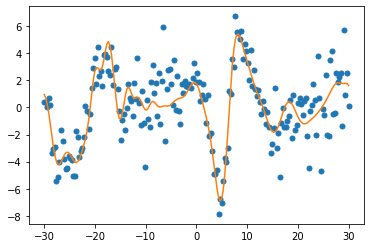

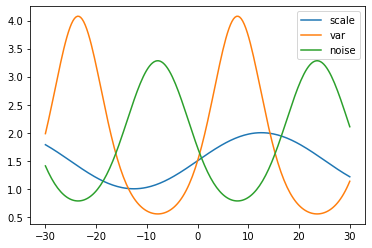

In [1]:
from common import *

os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "."
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

key = jax.random.PRNGKey(1221)
x, y, res_fn, true_fn = get_synth1d(key=key, n_points=200)

print(x.shape, y.shape)
plt.plot(x, y, ".", markersize=10)
plt.plot(x, true_fn)

plt.figure()
plt.plot(x, res_fn["scale"](x), label="scale")
plt.plot(x, res_fn["var"](x), label="var")
plt.plot(x, res_fn["noise"](x), label="noise")
plt.legend()

In [14]:
seed = 0
key = jax.random.PRNGKey(0)
num_inducing = 20
inducing_type = "random"
optimizer = optax.adam(learning_rate=0.05)
num_epochs = 1000
num_restarts = 10
flex_scale=False
flex_var=True
flex_noise=True

scale_prior = tfb.Log()(tfd.Gamma(5.0, 1.0))
var_prior = tfb.Log()(tfd.Gamma(0.5, 1.0))
std_prior = tfd.Normal(0.0, 1.0)

B.epsilon = 1e-4

################ Motorcycle helmet dataset

X, y, _ = rd.MotorcycleHelmet().get_data()

################ Jump dataset

# X, y, _ = rd.Jump1D().get_data()
# X, y, _, _, _ = get_simulated_data1()

################ Non-stat 2d
# X, y = get_nonstat_2d()

################ Heinonen D
# X, y = get_heinonen("Ds")


folds = get_folds(X, y, seed=seed)
results = []
pred_means = []
pred_covars = []
nlpd = []
rmse = []
msll = []
for fold_i in trange(len(folds)):
    X, y, X_test, y_test = folds[fold_i]
    gp = get_gibbs_gp(X, flex_scale=flex_scale, flex_var=flex_var, flex_noise=flex_noise, 
                      num_inducing=num_inducing, inducing_type=inducing_type)
    loss_fn = get_loss_fn(gp, X, y, scale_prior=scale_prior, var_prior=var_prior, std_prior=std_prior)
    partial_initialize_params = jtu.Partial(initialize_params, gp=gp, X=X, scale_prior=scale_prior, var_prior=var_prior)
    keys = jax.random.split(key, num=num_restarts)
    raw_params = jax.vmap(partial_initialize_params)(key=keys)
    partial_train_fn = jtu.Partial(train_fn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=num_epochs)
    result = jax.vmap(partial_train_fn)(raw_params=raw_params)
    best_result, best_params = extract_results(result)
    best_params = constrain(best_params, gp.get_bijectors())
    pred_mean, pred_cov = gp.predict(best_params, X, y, X_test)
    pred_means.append(pred_mean)
    pred_covars.append(pred_cov)
    nlpd.append(nlpd_fn(pred_mean, pred_cov, y_test))
    rmse.append(rmse_fn(pred_mean, y_test))
    msll.append(msll_fn(pred_mean, pred_cov, y_test))
    results.append(result)

  0%|          | 0/5 [00:00<?, ?it/s]

min_indices [995 981 978 988 883 949 999 920 985 998]
individual restart losses [70.82292984 70.78659177 70.77880522 70.85595349 70.8215243  70.82140662
 70.77899562 70.78027731 70.76266507 70.82082883]
best_restart 8 best_loss 70.76266506791488


 20%|██        | 1/5 [00:08<00:34,  8.68s/it]

min_indices [999 990 910 987 999 997 902 979 992 949]
individual restart losses [68.18211234 68.18626082 68.17636739 68.17361724 68.17026964 68.16914808
 68.16689255 68.17365048 68.17233125 68.17492325]
best_restart 6 best_loss 68.16689254555834


 40%|████      | 2/5 [00:17<00:25,  8.49s/it]

min_indices [981 982 980 989 993 949 994 996 943 999]
individual restart losses [65.74935793 65.74369398 65.74898109 65.74550383 65.75301328 65.76940815
 65.81321532 65.76613762 65.74338733 65.82100994]
best_restart 8 best_loss 65.74338732809395


 60%|██████    | 3/5 [00:27<00:18,  9.23s/it]

min_indices [993 994 989 984 977 952 966 977 992 992]
individual restart losses [71.86082864 71.86573949 71.85804411 71.86318609 71.86329088 71.85787564
 71.85647298 71.85689683 71.85744588 71.86026877]
best_restart 6 best_loss 71.85647297802865


 80%|████████  | 4/5 [00:35<00:09,  9.01s/it]

min_indices [990 959 996 972 979 940 972 935 982 963]
individual restart losses [72.64462721 72.64877641 72.64904838 72.66935333 72.63668085 72.63266399
 72.63431067 72.63684841 72.63452079 72.63833994]
best_restart 5 best_loss 72.63266399367005


100%|██████████| 5/5 [00:43<00:00,  8.78s/it]


In [15]:
print(f"RMSE: {list(map(lambda x: x.round(3).item(), rmse))}, avg: {np.mean(rmse).round(3)}")
print(f"NLPD: {list(map(lambda x: x.round(3).item(), nlpd))}, avg: {np.mean(nlpd).round(3)}")
print(f"MSLL: {list(map(lambda x: x.round(3).item(), msll))}, avg: {np.mean(msll).round(3)}")

RMSE: [0.47200000000000003, 0.401, 0.56, 0.359, 0.491], avg: 0.457
NLPD: [5.426, 5.638, 11.166, 2.332, 1.207], avg: 5.154
MSLL: [4.483, 5.742, 11.186, 1.696, 1.589], avg: 4.939


In paper, MSLL here is presented as NLPD by taking liberty with name.